In [ ]:
from google.colab import drive
drive.mount('/content/driver')

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [ ]:
BASE_DIR = '/content/driver/MyDrive/Colab Notebooks/Crypto-Forecasting/'
BTC_DIR = os.path.join(BASE_DIR, 'BTCUSDT_merged.csv')
ETH_DIR = os.path.join(BASE_DIR, 'ETHUSDT_merged.csv')

### BTC

In [ ]:
df_BTC = pd.read_csv(BTC_DIR)
df_BTC.head()

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
0,2019-09-01 00:00:00,9588.74,9630.00,9579.34,9617.06,546.960415,2019-09-01 00:59:59.999,5.257943e+06,7428,261.131656,2.510480e+06
1,2019-09-01 01:00:00,9617.06,9642.58,9612.08,9614.99,453.105152,2019-09-01 01:59:59.999,4.362498e+06,5789,258.764082,2.491295e+06
2,2019-09-01 02:00:00,9614.99,9616.00,9595.76,9605.78,458.004517,2019-09-01 02:59:59.999,4.400751e+06,5485,321.355630,3.088171e+06
3,2019-09-01 03:00:00,9606.12,9624.01,9605.78,9623.02,633.588749,2019-09-01 03:59:59.999,6.092024e+06,5500,446.853542,4.296649e+06
4,2019-09-01 04:00:00,9623.02,9630.21,9605.60,9614.46,542.260896,2019-09-01 04:59:59.999,5.216076e+06,5536,368.470786,3.544535e+06


In [ ]:
# quick overview the dataset
df_BTC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32821 entries, 0 to 32820
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   open_time               32821 non-null  object 
 1   open                    32821 non-null  float64
 2   high                    32821 non-null  float64
 3   low                     32821 non-null  float64
 4   close                   32821 non-null  float64
 5   volume                  32821 non-null  float64
 6   close_time              32821 non-null  object 
 7   quote_volume            32821 non-null  float64
 8   count                   32821 non-null  int64  
 9   taker_buy_volume        32821 non-null  float64
 10  taker_buy_quote_volume  32821 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 2.8+ MB


In [ ]:
# set open time as an index
df_BTC = df_BTC.set_index('open_time')

In [ ]:
# convert the object into datetime format
df_BTC.index = pd.to_datetime(df_BTC.index, format="%Y-%m-%d")

### Plot

In [ ]:
def plot_series(data, string):
  fig, ax = plt.subplots(figsize=(20, 6))
  plt.plot(data[string])
  plt.xlabel('Date')
  plt.ylabel(string)

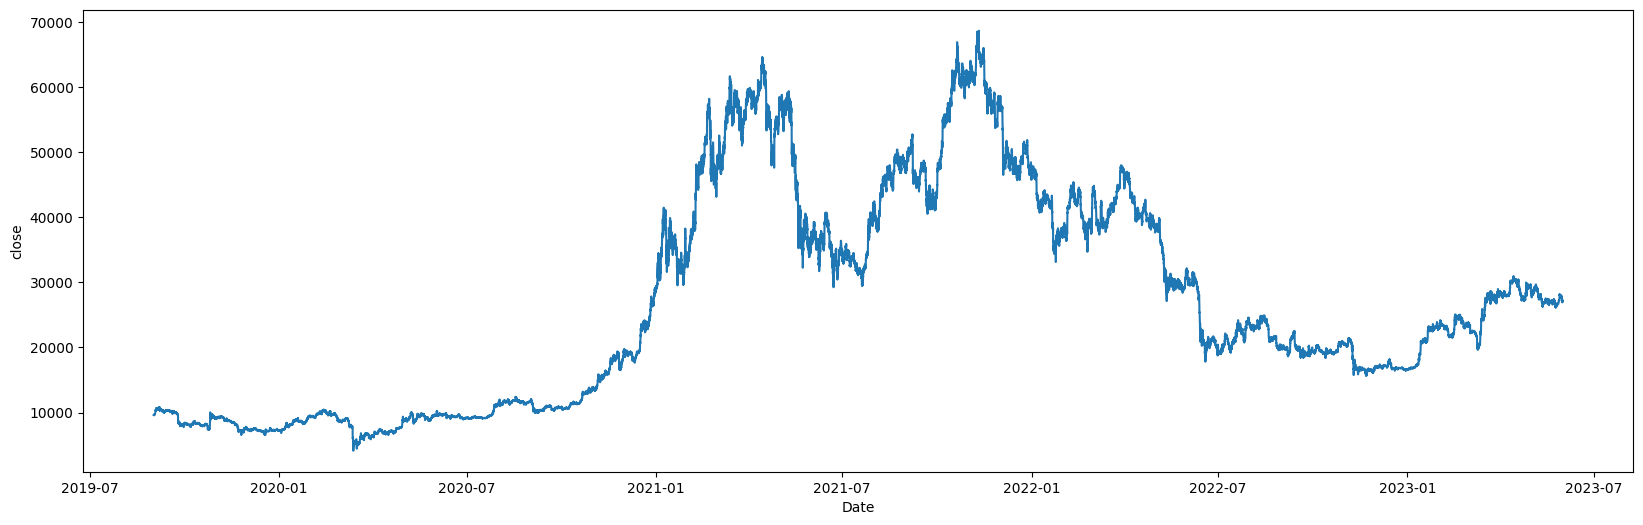

In [ ]:
# Plot close price of BTC
plot_series(df_BTC, 'close')

<Axes: >

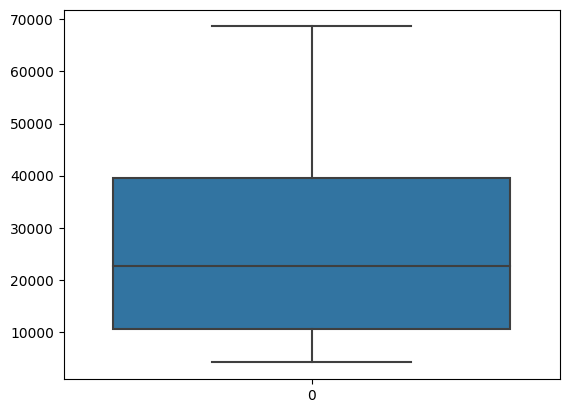

In [ ]:
sns.boxplot(df_BTC['close'])

### Split the Dataset

In [ ]:
cutoff_test = int(len(df_BTC)*.9)

btc_train = df_BTC['close'][:cutoff_test]
btc_test = df_BTC['close'][cutoff_test:]

### Naive Forecast

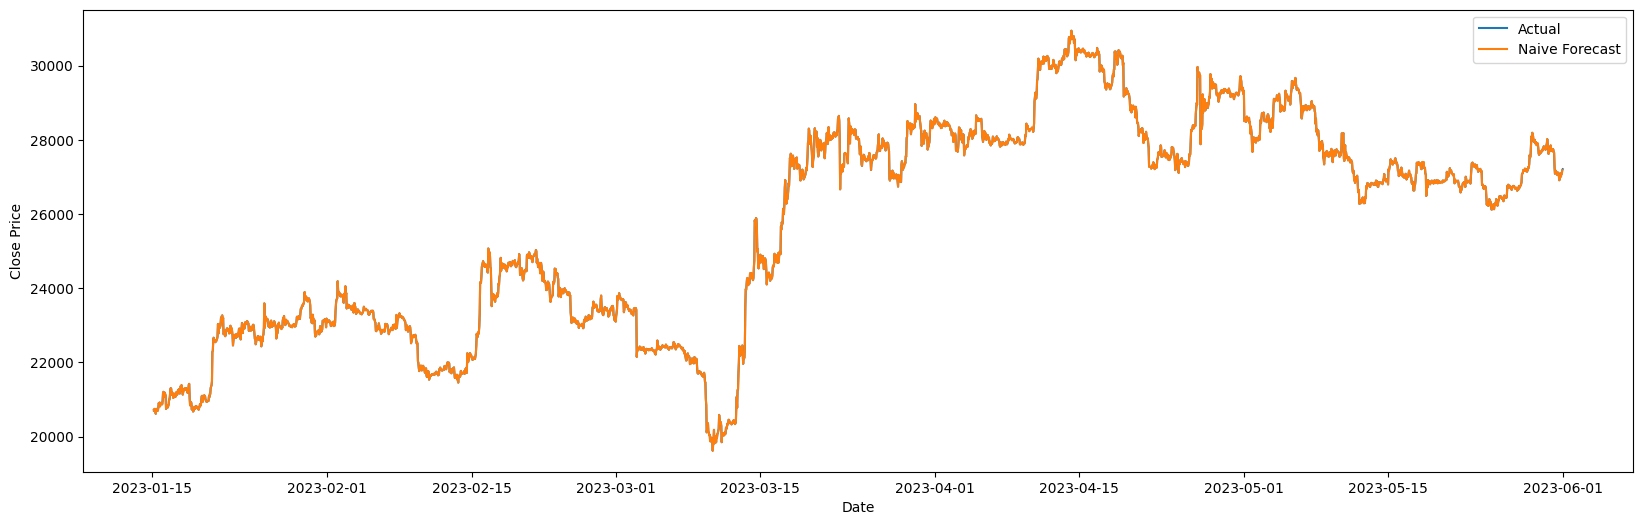

In [ ]:
naive_forecast = df_BTC['close'][cutoff_test-1:-1]

fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(btc_test, label="Actual")
plt.plot(naive_forecast, label="Naive Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()

### Computing Metrics

In [ ]:
def computing_metrics(actual, predicted):
  """
    Agrs:
      actual: pd.Series
      predicted: pd.Series

    Returns:
      mse: float    -> mean squared error
      mae: float    -> mean absolute error
  """
  # caculate mean squared error
  mse = tf.keras.metrics.mean_squared_error(actual, predicted).numpy()
  # calculate mean absolute error
  mae = tf.keras.metrics.mean_absolute_error(actual, predicted).numpy()

  return mse, mae

In [ ]:
# calculate the mae and mse of naive forecast

mse, mae = computing_metrics(btc_test, naive_forecast)

print(f"Mean Squared Error: {round(mse, 3)}")
print(f"Mean Absolute Error: {round(mae, 3)}")

Mean Squared Error: 18386.188
Mean Absolute Error: 80.885


In [ ]:
btc_train

open_time
2019-09-01 00:00:00     9617.06
2019-09-01 01:00:00     9614.99
2019-09-01 02:00:00     9605.78
2019-09-01 03:00:00     9623.02
2019-09-01 04:00:00     9614.46
                         ...   
2023-01-14 23:00:00    20954.92
2023-01-15 00:00:00    20767.05
2023-01-15 01:00:00    20770.29
2023-01-15 02:00:00    20672.91
2023-01-15 03:00:00    20719.09
Name: close, Length: 29538, dtype: float64

### Normalization

In [ ]:
scaler = MinMaxScaler()
close_price = btc_train.values.reshape(-1, 1)
# df_BTC['close']= scaler.fit_transform(close_price)
btc_train_scaled = scaler.fit_transform(close_price)

### Prepare features and labels

In [ ]:
def windowed(data, window_size, batch_size, shuffle_buffer):
  """
    Args:
      data: array of float
      window_size: int
      batch_size: int
      shuffle_buffer: int

    Returns:
      data: tf.Dataset
  """

  # Generate a TF Dataset
  data = tf.data.Dataset.from_tensor_slices(data)

  # window the data
  data = data.window(window_size+1, shift=1, drop_remainder=True)

  # Flatten the windows
  data = data.flat_map(lambda window: window.batch(window_size + 1))

  # create a tuples with features and labels
  data = data.map(lambda window: (window[:-1], window[-1]))

  # shuffle the windows
  data = data.shuffle(shuffle_buffer)

  # create batchs
  data = data.batch(batch_size).prefetch(1)

  return data

### Parameters

In [ ]:
window_size = 10
batch_size = 256
shuffle_buffer = 1000

### Generate dataset windows

In [ ]:
data_btc = windowed(btc_train_scaled, window_size, batch_size, shuffle_buffer)

In [ ]:
for window in data_btc.take(1):
  print(f'data type: {type(window)}')
  print(f'number of elements in the tuple: {len(window)}')
  print(f'shape of feature of first element: {window[0].shape}')
  print(f'shape of labels of first element: {window[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of feature of first element: (512, 15, 1)
shape of labels of first element: (512, 1)


### Build the Model

In [2]:
def build_model(window_size):
  """
    Args:
      window_size: int

    Returns:
      model:
  """
  model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu')),
      # tf.keras.layers.Dropout(0.2),
      # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu')),
      # tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 400)
  ])



  return model

### Tune the Learning Rate

In [ ]:
def tune_learning_rate(model, data):
  """
    Args:
      model:
      data:

    Returns:
      history
  """

  # set learning rate scheduler
  lr_schedule = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-8 * 10 ** (epoch/10))

  # Initialize the optimizer
  optimizer = tf.keras.optimizers.Adam()

  # compile the model
  model.compile(
      loss="mse",
      # loss=tf.keras.losses.Huber(),
      optimizer=optimizer
  )

  history = model.fit(data, epochs=100, callbacks=[lr_schedule])

  return history

In [ ]:
epoch = 100
1e-8 * 8 ** (epoch/10)

10.73741824

In [ ]:
# build the model
model_tune = build_model(window_size)
lr_history = tune_learning_rate(model_tune, data_btc)

Epoch 1/100
58/58 [==============================] - 36s 436ms/step - loss: 25.4922 - lr: 1.0000e-08
Epoch 2/100
58/58 [==============================] - 25s 428ms/step - loss: 25.3650 - lr: 1.2589e-08
Epoch 3/100
58/58 [==============================] - 25s 436ms/step - loss: 25.3167 - lr: 1.5849e-08
Epoch 4/100
58/58 [==============================] - 25s 429ms/step - loss: 25.6100 - lr: 1.9953e-08
Epoch 5/100
58/58 [==============================] - 23s 399ms/step - loss: 25.0771 - lr: 2.5119e-08
Epoch 6/100
58/58 [==============================] - 24s 413ms/step - loss: 24.9361 - lr: 3.1623e-08
Epoch 7/100
58/58 [==============================] - 25s 427ms/step - loss: 25.2384 - lr: 3.9811e-08
Epoch 8/100
58/58 [==============================] - 25s 426ms/step - loss: 25.0637 - lr: 5.0119e-08
Epoch 9/100
58/58 [==============================] - 29s 502ms/step - loss: 24.9463 - lr: 6.3096e-08
Epoch 10/100
58/58 [==============================] - 25s 427ms/step - loss: 24.0694 - lr: 

### Plot Learning Rate

In [ ]:
def plot_learning_rate(history, zoom_split):
  # learning rate array
  lr = 1e-8 * (10**(np.arange(100)/20))
  plt.figure(figsize=(10,6))
  plt.semilogx(history.history['lr'][:zoom_split], history.history['loss'][:zoom_split])
  plt.tick_params('both', length=10, width=1, which='both')
  # plt.axis([1e-8, 100])

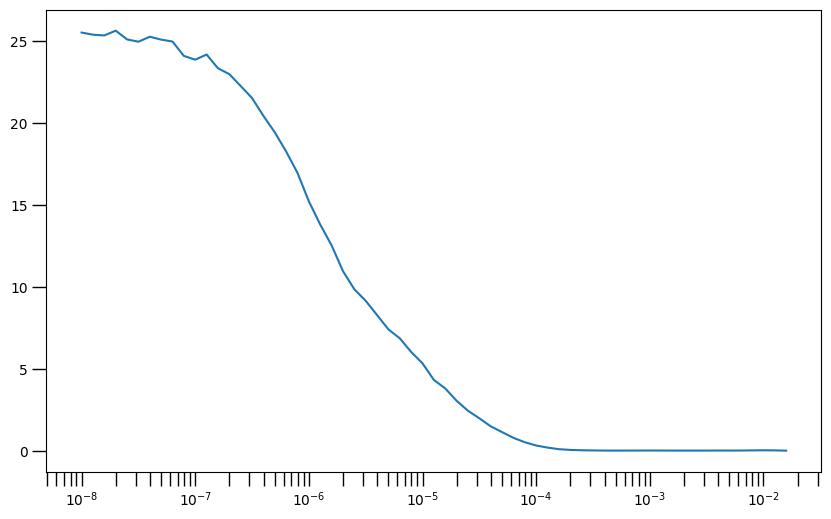

In [ ]:
plot_learning_rate(lr_history, zoom_split=63)

In [ ]:
def compile_model(model, data):
  # set the learning rate
  learning_rate = 1e-3

  # set the optimizer
  # optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  # set the training parameters
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae']
                )

  # train the model
  history = model.fit(data, epochs=50)

  return history

In [ ]:
# reset the states
tf.keras.backend.clear_session()

# build the model
model = build_model(window_size)

# train the model
history = compile_model(model, data_btc)

Epoch 1/50
58/58 [==============================] - 29s 376ms/step - loss: 1.2405 - mae: 0.7438
Epoch 2/50
58/58 [==============================] - 20s 338ms/step - loss: 0.1386 - mae: 0.2596
Epoch 3/50
58/58 [==============================] - 22s 371ms/step - loss: 0.0942 - mae: 0.2134
Epoch 4/50
58/58 [==============================] - 22s 384ms/step - loss: 0.0711 - mae: 0.1868
Epoch 5/50
58/58 [==============================] - 21s 359ms/step - loss: 0.0505 - mae: 0.1557
Epoch 6/50
58/58 [==============================] - 21s 359ms/step - loss: 0.0379 - mae: 0.1332
Epoch 7/50
58/58 [==============================] - 21s 349ms/step - loss: 0.0286 - mae: 0.1146
Epoch 8/50
58/58 [==============================] - 20s 334ms/step - loss: 0.0218 - mae: 0.0975
Epoch 9/50
58/58 [==============================] - 21s 351ms/step - loss: 0.0179 - mae: 0.0875
Epoch 10/50
58/58 [==============================] - 23s 399ms/step - loss: 0.0144 - mae: 0.0777
Epoch 11/50
58/58 [====================

Text(0, 0.5, 'Loss')

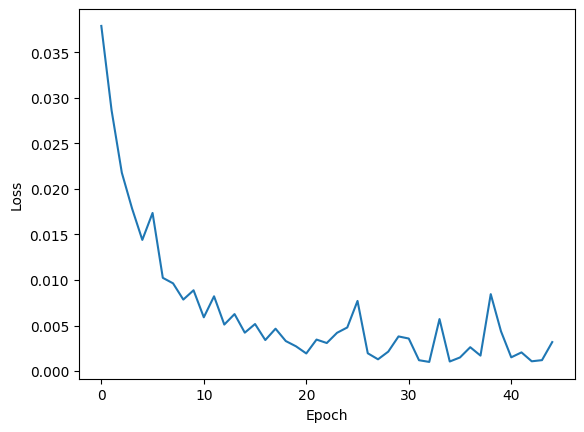

In [ ]:
# get mae and loss from history log
mae = history.history['mae']
loss = history.history['loss']

# get epochs number
epochs = range(len(loss))

# plot
# plt.plot(history.history['mae'])
plt.plot(history.history['loss'][5:])
plt.xlabel('Epoch')
plt.ylabel('Loss')

### Save Model

In [ ]:
MODEL_DIR = os.path.join(BASE_DIR, 'BTC_saved_model.h5')
model.save(MODEL_DIR)

### Model Prediction

In [ ]:
# Normalize test set
close_price = btc_test.values.reshape(-1, 1)
btc_test_scaled = scaler.transform(close_price)

In [ ]:
forecast = []

# reduce the original series
forecast_series = df_BTC['close'][cutoff_test-window_size:]

# Normalize the forecast series
close_price = forecast_series.values.reshape(-1, 1)
forecast_scaled = scaler.transform(close_price)

In [ ]:
# use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  prediction = model.predict(forecast_scaled[time:time + window_size][np.newaxis])
  forecast.append(prediction)

# convert to a numpy array and drop single dimensional axis
result = np.array(forecast).squeeze()

1/1 [==============================] - 0s 39ms/step


In [ ]:
# inverse the normalization
btc_forecast = scaler.inverse_transform(result.reshape(-1,1))
btc_forecast = np.array(btc_forecast).squeeze()

In [ ]:
mse, mae = computing_metrics(btc_test, btc_forecast)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 13561775.0
Mean Absolute Error: 3651.93603515625
